# Clustering evaluation on high dimensional data

The goal of this notebook is to provide a basic template walkthrough of obtaining and preparing a number of (simple) high dimensional datasets that can reasonably used to clustering evaluation. The datasets chosen have associated class labels that *should* be meaningful in terms of how the data clusters, and thus we can use label based clustering evaluation such as ARI and AMI to determine how well different clustering approaches are performing.

The primary purpose of this notebook is to provide a set of baseline datasets that clustering algorithm developers can try their algorithms out on. Performing reasinably well on these datasets is a necessary but not sufficient condition of a good clustering algorithm.

In [19]:
!git branch

  main
* prune_graph


In [2]:
data_folder = '../data'

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn import cluster

import numpy as np
import pandas as pd
import requests
import zipfile
import imageio
import os
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import cdlib.algorithms as cd

import partition_networkx
from community import community_louvain, ecg, modularity
from networkx.algorithms.community import label_propagation_communities
import leidenalg as la
import igraph as ig

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


# MNIST, USPS and Pendigits are easy

We can use the sklearn API to fetch data for the Pendigits, MNIST and USPS datasets.

Of these datasets pendigits is the smallest, with only 1797 samples, and is only 64 dimensional. This makes a good first dataset to test things out on -- the dataset is small enough that practically anything should be able to run on this efficiently.

USPS provides a slightly more challenging dataset, with almost 10,000 samples and 256 dimensions, but is still samall enough to be tractable for even naive clustering implementations.

MNIST provides a good basic scaling test with 70,000 samples in 784 dimensions. In practice this is not a very large dataset compared to many that people want to cluster, although the dimensionality may provide some challenges.

In [4]:
digits = load_digits()
mnist = fetch_openml("MNIST_784")
usps = fetch_openml("USPS")

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [5]:
def eval_clusters(cluster_labels, true_labels, raw_data, cluster_method="None", min_cluster_size=5):
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes == 1): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes <= min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if np.any(cluster_labels < 0): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [6]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75):
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe["Dim Reduction"].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe["Dim Reduction"] == dim_red)
            ]
            nb_method = sub_dataframe.shape[0]
            axs[i].bar(
                x=x_positions[:nb_method],
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions[:nb_method] = x_positions[:nb_method] + bar_width
        x_positions[nb_method:] = x_positions[nb_method:] + 0.5*bar_width
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

In [49]:
def run_graph_clustering_algorithm(algo_list, G, weight = 'umap_weight'):
    n_points = G.number_of_nodes()
    clustering_results = dict()
    clustering_labels = dict()
    for algo in algo_list:
        print(f"Running {algo}...")
        if algo == 'Louvain':
            clustering_results[algo] = community_louvain.best_partition(G)
        elif algo == 'Louvain \n+ weight':
            clustering_results[algo] = community_louvain.best_partition(G, weight=weight)
        elif algo == 'Label \nPropagation':
            lp_graph_list = list(label_propagation_communities(G)) 
            clustering_results[algo] = {v:com for com, comSet in enumerate(list(lp_graph_list)) for v in comSet}
        elif algo == 'ECG':
            clustering_results[algo] = ecg(G, ens_size=32, min_weight=).partition
        elif algo == 'Leiden':
            iG = ig.Graph.from_networkx(G)
            clustering_results[algo] = {i:v for i, v in enumerate(la.find_partition(iG, la.ModularityVertexPartition).membership)}
        elif algo == 'Leiden \n+ weight':
            iG = ig.Graph.from_networkx(G)
            clustering_results[algo] = {i:v for i, v in enumerate(la.find_partition(iG, la.ModularityVertexPartition, weights=weight).membership)} 
        clustering_labels[algo] = np.array([clustering_results[algo][i] for i in range(n_points)])
    return(clustering_results, clustering_labels)       

In [8]:
def evaluation_dataframe(clustering_labels, true_labels, raw_data):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo) for algo, algo_labels in clustering_labels.items() 
        ]
    )
    return(eval_results)

In [9]:
def print_summary(clustering_results, G):
    for method, results in clustering_results.items():
        print(f"{method}: \n\tModularity: {modularity(results, G):.2f}, \n\tPartition size: {max(results.values())}") 

In [10]:
algo_list = ['Louvain', 'ECG']

# Pendigits clustering scores

In [20]:
raw_pendigits = digits.data.astype(np.float32)

### Build graph from UMAP weights - run graph algorithms

In [30]:
A, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_pendigits, 
                                                         n_neighbors=15, 
                                                         random_state=0, 
                                                         metric='euclidean', 
                                                         return_dists=True)
G_pendigits = nx.from_scipy_sparse_matrix(A, edge_attribute='umap_weight')
n_points = A.shape[0]

### Ensemble effect
The ensemble weights are obtained from a concensus of the first levels of multiple runs of Louvain. In general, the first level of Louvain is a fine and unstable partition of the vertices (this as been checked on LFR graphs). However, as we can see here, the first level of Louvain is somewhat stable on this graph. 

In [88]:
ecg_pendigits = ecg(G_pendigits, ens_size=32)
ecg_pendigits_labels = np.array([ecg_pendigits.partition[i] for i in range(n_points)])

In [77]:
n_runs = 10
stability_ami = [0]*n_runs
stability_ari = [0]*n_runs
stability_gam = [0]*n_runs
ecg_level1_ari = [0]*n_runs
ecg_level1_ami = [0]*n_runs
ecg_level1_gam = [0]*n_runs
for i in range(n_runs):
    lv_dict_1 = community_louvain.partition_at_level(community_louvain.generate_dendrogram(G_pendigits),0)
    lv_pendigits_results_1 = np.array([lv_dict_1[i] for i in range(n_points)])
    lv_dict_2 = community_louvain.partition_at_level(community_louvain.generate_dendrogram(G_pendigits),0)
    lv_pendigits_results_2 = np.array([lv_dict_2[i] for i in range(n_points)])
    stability_ari[i] = adjusted_rand_score(lv_pendigits_results_1, lv_pendigits_results_2)
    stability_ami[i] = adjusted_mutual_info_score(lv_pendigits_results_1, lv_pendigits_results_2)
    stability_gam[i] = G_pendigits.gam(lv_dict_1, lv_dict_2)
    ecg_level1_ari[i] = adjusted_rand_score(lv_pendigits_results_1, ecg_pendigits_labels)
    ecg_level1_ami[i] = adjusted_mutual_info_score(lv_pendigits_results_1, ecg_pendigits_labels)
    ecg_level1_gam[i] = G_pendigits.gam(lv_dict_1, ecg_pendigits.partition)

In [83]:
print('Stability of first level of Louvain')
print(f"ARI: {[ '%.2f' % elem for elem in stability_ari ]}")
print(f"AMI: {[ '%.2f' % elem for elem in stability_ami ]}")
print(f"GAM: {[ '%.2f' % elem for elem in stability_gam ]}")

Stability of first level of Louvain
ARI: ['0.66', '0.63', '0.63', '0.72', '0.66', '0.71', '0.58', '0.70', '0.78', '0.59']
AMI: ['0.86', '0.85', '0.85', '0.87', '0.87', '0.88', '0.84', '0.88', '0.89', '0.83']
GAM: ['0.53', '0.50', '0.49', '0.52', '0.55', '0.57', '0.47', '0.55', '0.58', '0.46']


In [82]:
print('Similarity of first level of Louvain and ECG final clustering')
print(f"ARI: {[ '%.2f' % elem for elem in ecg_level1_ari]}")
print(f"AMI: {[ '%.2f' % elem for elem in ecg_level1_ami ]}")
print(f"GAM: {[ '%.2f' % elem for elem in ecg_level1_gam ]}")

Similarity of first level of Louvain and ECG final clustering
ARI: ['0.69', '0.55', '0.56', '0.67', '0.64', '0.75', '0.53', '0.67', '0.76', '0.61']
AMI: ['0.87', '0.83', '0.84', '0.86', '0.86', '0.87', '0.83', '0.86', '0.89', '0.85']
GAM: ['0.49', '0.40', '0.45', '0.50', '0.51', '0.53', '0.42', '0.51', '0.61', '0.47']


0


<AxesSubplot:ylabel='Density'>

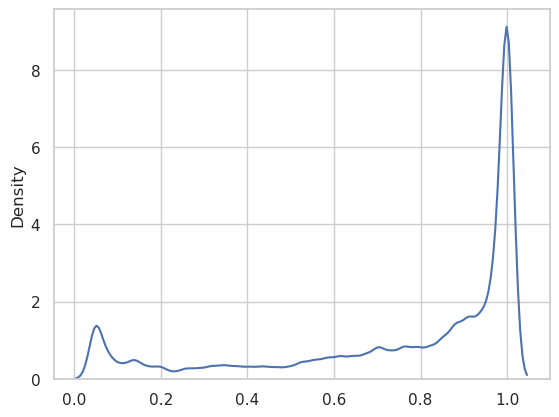

In [89]:
sns.set_style('whitegrid')
ecg_weight_array = np.array(list(ecg_pendigits.W.values()))
print(sum(ecg_weight_array==0))
sns.kdeplot(ecg_weight_array, bw=0.05)

In [ ]:
ecg_varyW_labels_pendigits = dict()
for w in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(w)
    ecg_pendigits_dict = ecg(G_pendigits, ens_size=32, min_weight=w).partition
    ecg_varyW_labels_pendigits[f'ECG ({w})'] = np.array([ecg_pendigits_dict[i] for i in range(n_points)])
pendigits_ECG_results = evaluation_dataframe(ecg_varyW_labels_pendigits, digits.target, raw_pendigits)

In [62]:
for k, v in ecg_varyW_labels_pendigits.items():
    print(f'{k}: {max(v)}')

ECG (0): 26
ECG (0.1): 22
ECG (0.2): 17
ECG (0.3): 15
ECG (0.4): 13
ECG (0.5): 14


Louvain: 
	Modularity: 0.86, 
	Partition size: 11
ECG: 
	Modularity: 0.85, 
	Partition size: 16


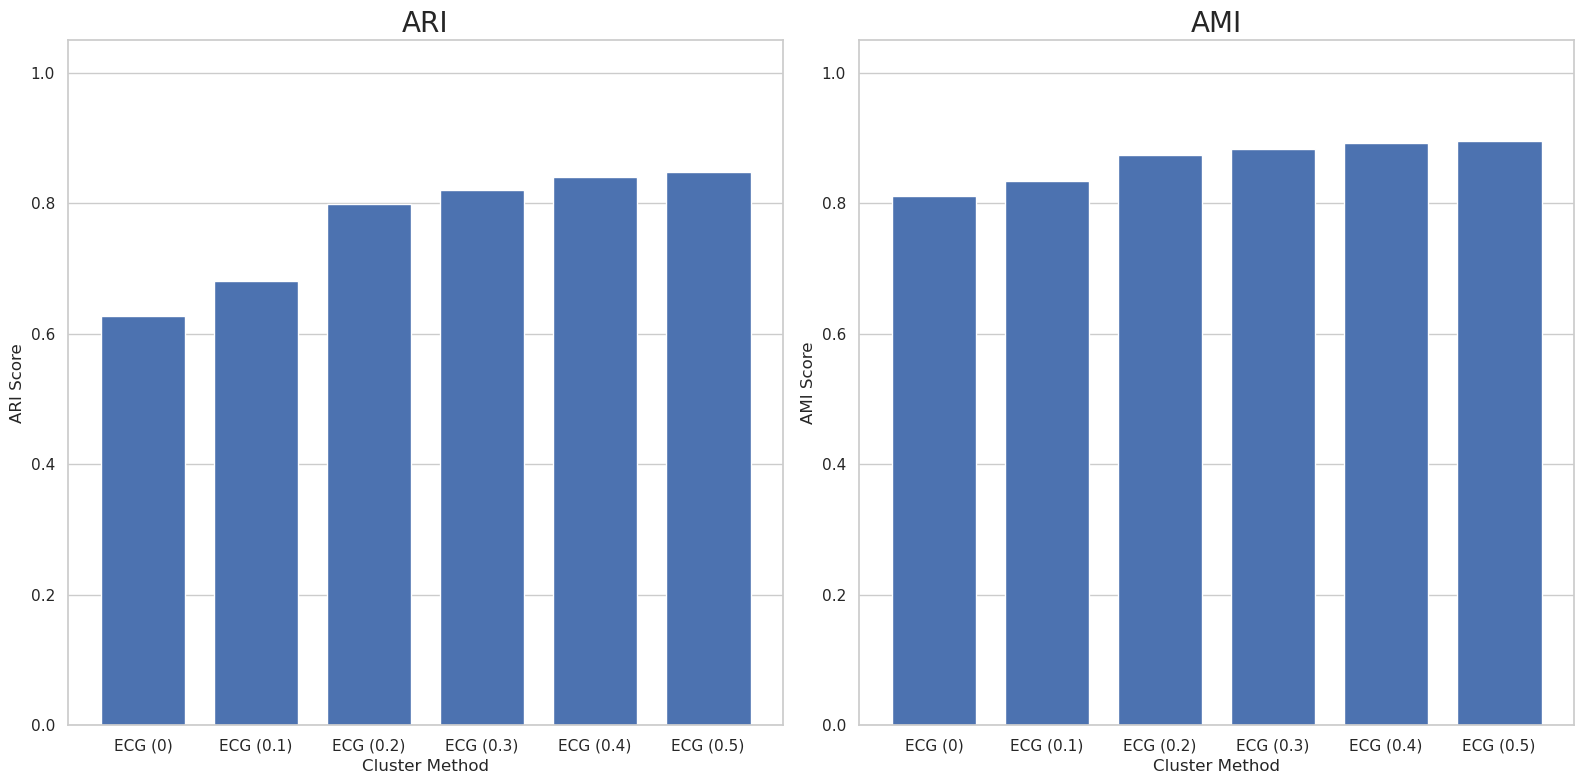

In [58]:
pendigits_umap_results_long = pendigits_ECG_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_umap_results_long["Dim Reduction"] = "UMAP"
print_summary(clustering_results_pendigits, G_pendigits)
plot_scores(pendigits_umap_results_long)

In [ ]:
from networkx import LFR_benchmark_graph
LFR_benchmark_graph(10, tau1, tau2, mu=0.8)

# COIL-20 Clustering

In [18]:
import re
images_zip = zipfile.ZipFile(f'{data_folder}/coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))
images_zip.extractall(data_folder + '/.')

In [19]:
%%time
coil_feature_vectors = []
for filename in filelist:
    im = imageio.imread(data_folder + '/' + filename)
    coil_feature_vectors.append(im.flatten())
coil_20_data = np.asarray(coil_feature_vectors)
coil_20_target = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False).values.astype(np.int32)

CPU times: user 381 ms, sys: 35.9 ms, total: 417 ms
Wall time: 421 ms


In [20]:
raw_coil = coil_20_data.astype(np.float32)

### Build graph from UMAP weights - run graph algorithms

In [21]:
A_coil, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_coil,
                                                            n_neighbors=5,  
                                                            random_state=0, 
                                                         metric='euclidean', 
                                                         return_dists=True)
G_coil = nx.from_scipy_sparse_matrix(A_coil, edge_attribute='umap_weight')

In [22]:
%%time
clustering_results_coil, clustering_labels_coil  = run_graph_clustering_algorithm(algo_list, G_coil)
coil_graph_results = evaluation_dataframe(clustering_labels_coil, coil_20_target, raw_coil)

CPU times: user 38.7 s, sys: 912 ms, total: 39.7 s
Wall time: 8.87 s


### UMAP reduction

In [23]:
umap_coil = umap.UMAP(n_neighbors=5, n_components=4, min_dist=1e-8, random_state=0, n_epochs=1000).fit_transform(raw_coil)

In [24]:
%%time
# km_umap_labels = cluster.KMeans(n_clusters=20).fit_predict(umap_coil)
# cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(umap_coil)
# sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_coil)
db_umap_labels = cluster.DBSCAN(eps=0.3).fit_predict(umap_coil)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_coil)

CPU times: user 19.9 ms, sys: 4 ms, total: 23.9 ms
Wall time: 22.9 ms


In [25]:
coil_umap_results_part = evaluation_dataframe({'DBSCAN':db_umap_labels, 'HDBSCAN':hd_umap_labels}, coil_20_target, raw_coil)
coil_umap_results = pd.concat([coil_umap_results_part, coil_graph_results])
coil_umap_results_long = coil_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_umap_results_long["Dim Reduction"] = "UMAP"

Louvain: 
	Modularity: 0.93, 
	Partition size: 26
Louvain 
+ weight: 
	Modularity: 0.92, 
	Partition size: 28
Label 
Propagation: 
	Modularity: 0.68, 
	Partition size: 282
ECG: 
	Modularity: 0.90, 
	Partition size: 67
Leiden: 
	Modularity: 0.93, 
	Partition size: 26
Leiden 
+ weight: 
	Modularity: 0.92, 
	Partition size: 28


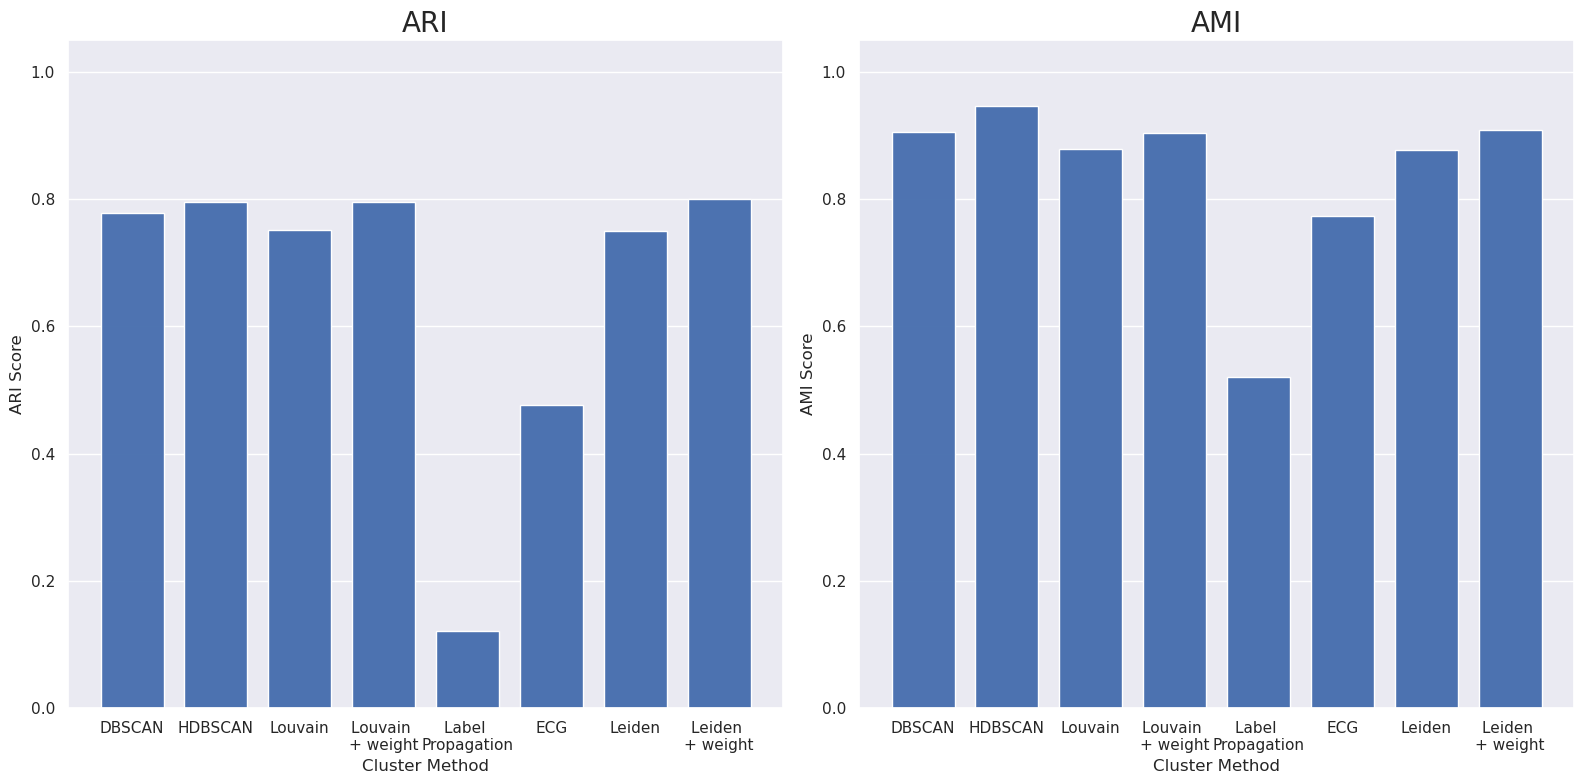

In [26]:
print_summary(clustering_results_coil, G_coil)
plot_scores(coil_umap_results_long)

# MNIST Clustering

In [27]:
raw_mnist = mnist.data.astype(np.float32)[:35000]

### Build graph from UMAP weights - run graph algorithms

In [28]:
A_mnist, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_mnist,
                                                            n_neighbors=10,  
                                                            random_state=42, 
                                                         metric='euclidean', 
                                                         return_dists=True)
G_mnist = nx.from_scipy_sparse_matrix(A_mnist, edge_attribute='umap_weight')

In [29]:
%%time
clustering_results_mnist, clustering_labels_mnist  = run_graph_clustering_algorithm(algo_list, G_mnist)
mnist_graph_results = evaluation_dataframe(clustering_labels_mnist, mnist.target[:35000], raw_mnist)

CPU times: user 1h 1min 28s, sys: 37.8 s, total: 1h 2min 6s
Wall time: 47min 5s


### UMAP reduction

In [30]:
umap_mnist = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_mnist)

In [31]:
%%time
# km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_mnist)
# cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_mnist)
# sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_mnist)
db_umap_labels = cluster.DBSCAN(eps=0.1).fit_predict(umap_mnist)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_mnist)

CPU times: user 656 ms, sys: 165 ms, total: 820 ms
Wall time: 1.37 s


In [32]:
mnist_umap_results_part = evaluation_dataframe({'DBSCAN':db_umap_labels, 'HDBSCAN':hd_umap_labels}, mnist.target[:35000], raw_mnist)
mnist_umap_results = pd.concat([mnist_umap_results_part, mnist_graph_results])
mnist_umap_results_long = mnist_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_umap_results_long["Dim Reduction"] = "UMAP"

Louvain: 
	Modularity: 0.85, 
	Partition size: 12
Louvain 
+ weight: 
	Modularity: 0.84, 
	Partition size: 16
Label 
Propagation: 
	Modularity: 0.61, 
	Partition size: 846
ECG: 
	Modularity: 0.83, 
	Partition size: 27
Leiden: 
	Modularity: 0.86, 
	Partition size: 12
Leiden 
+ weight: 
	Modularity: 0.85, 
	Partition size: 17


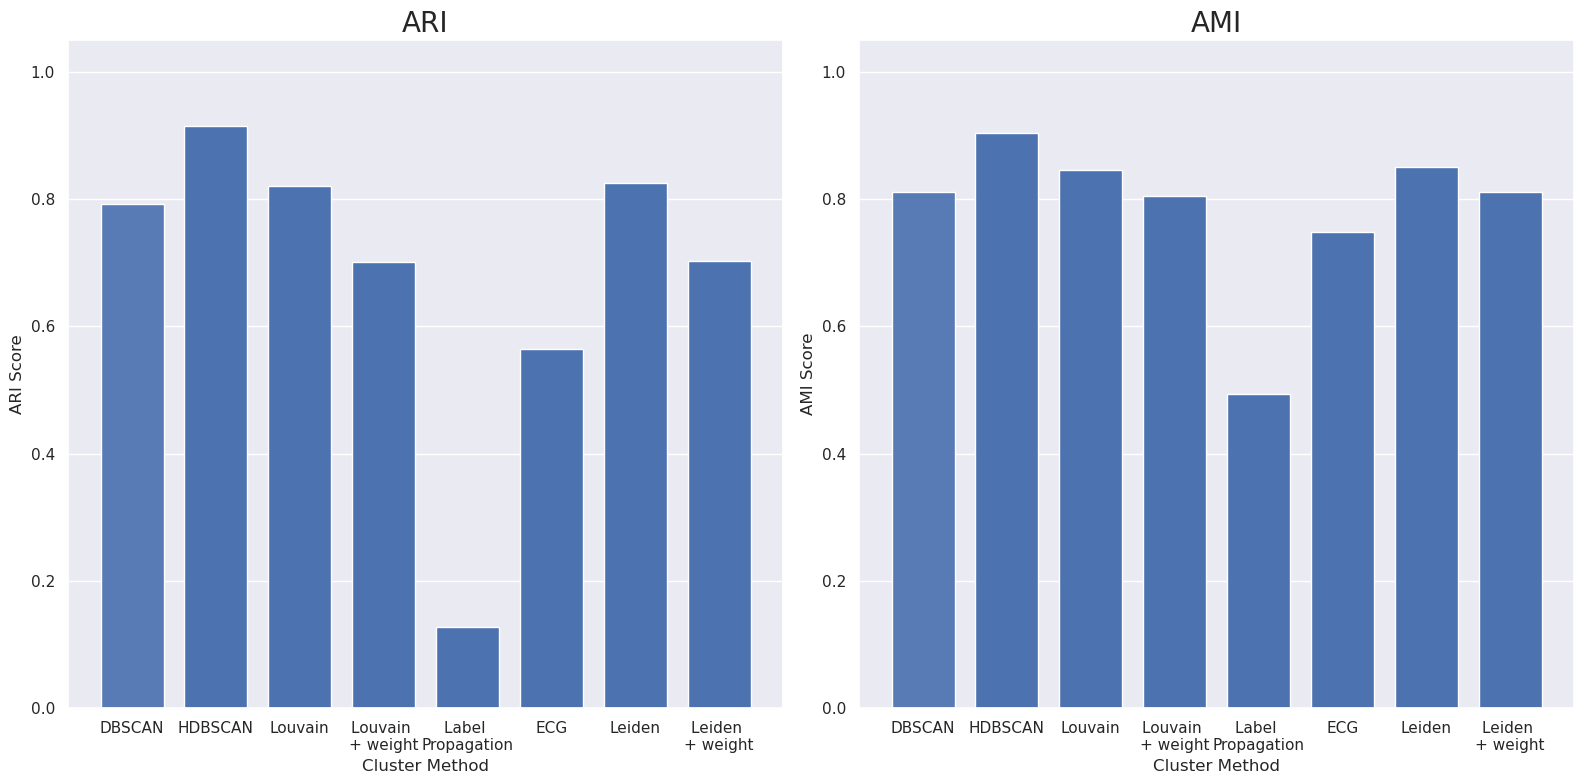

In [33]:
print_summary(clustering_results_mnist, G_mnist)
plot_scores(mnist_umap_results_long)

# USPS Clustering

In [34]:
raw_usps = usps.data.astype(np.float32)

### Build graph from UMAP weights - run graph algorithms

In [35]:
A_usps, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_usps,
                                                            n_neighbors=10,  
                                                            random_state=42, 
                                                         metric='euclidean', 
                                                         return_dists=True)
G_usps = nx.from_scipy_sparse_matrix(A_usps, edge_attribute='umap_weight')

In [36]:
%%time
clustering_results_usps, clustering_labels_usps  = run_graph_clustering_algorithm(algo_list, G_usps)
usps_graph_results = evaluation_dataframe(clustering_labels_usps, usps.target, raw_usps)

CPU times: user 5min 44s, sys: 2.02 s, total: 5min 46s
Wall time: 4min 59s


### UMAP reduction

In [37]:
umap_usps = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_usps)

In [38]:
%%time
# km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_usps)
# cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_usps)
# sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_usps)
db_umap_labels = cluster.DBSCAN(eps=0.15).fit_predict(umap_usps)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_usps)

CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 181 ms


In [39]:
usps_umap_results_part = evaluation_dataframe({'DBSCAN':db_umap_labels, 'HDBSCAN':hd_umap_labels}, usps.target, raw_usps)
usps_umap_results = pd.concat([usps_umap_results_part, usps_graph_results])
usps_umap_results_long = usps_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_umap_results_long["Dim Reduction"] = "UMAP"

Louvain: 
	Modularity: 0.86, 
	Partition size: 11
Louvain 
+ weight: 
	Modularity: 0.85, 
	Partition size: 13
Label 
Propagation: 
	Modularity: 0.64, 
	Partition size: 271
ECG: 
	Modularity: 0.83, 
	Partition size: 30
Leiden: 
	Modularity: 0.86, 
	Partition size: 11
Leiden 
+ weight: 
	Modularity: 0.86, 
	Partition size: 13


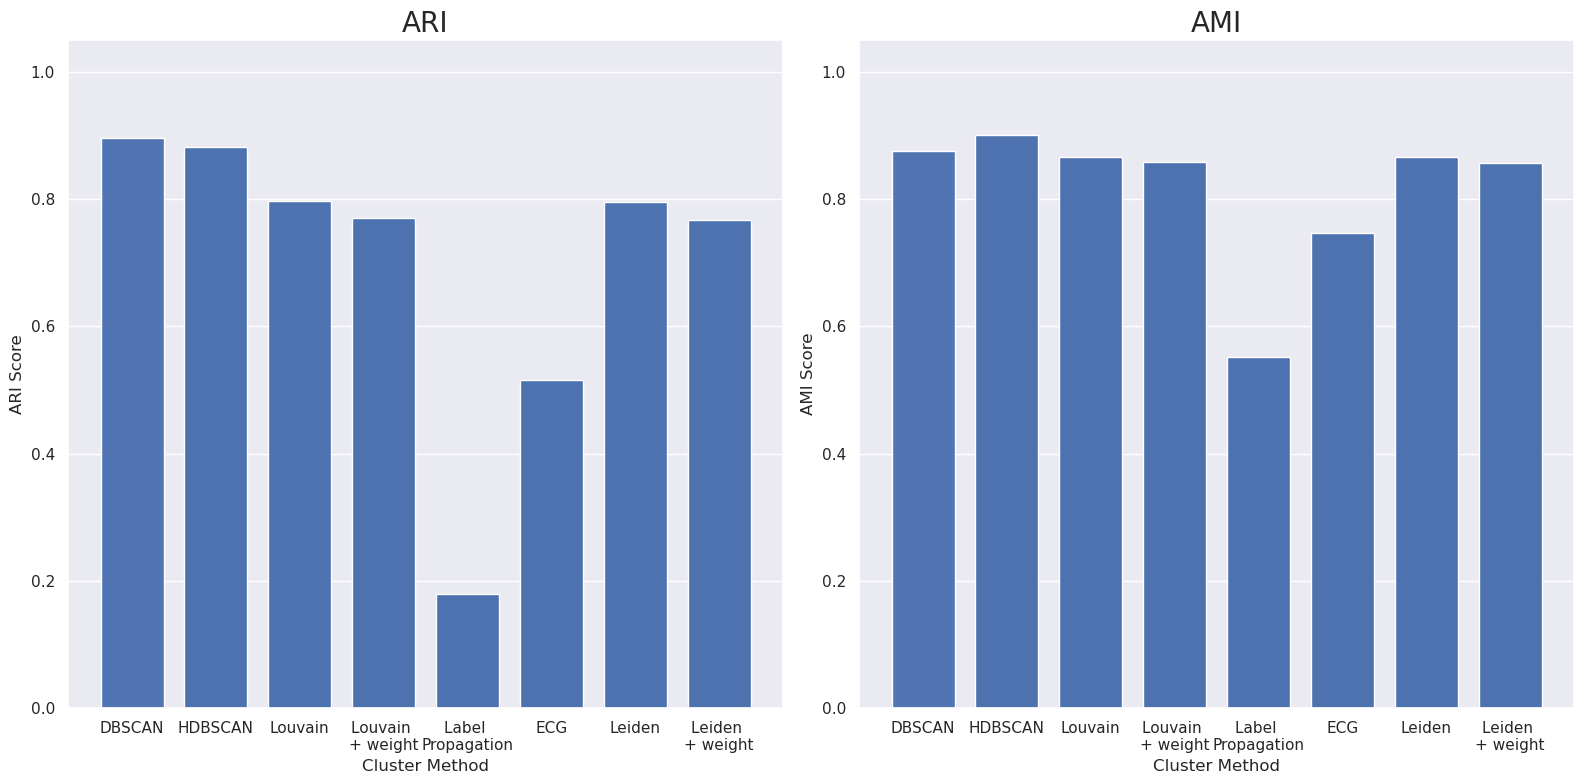

In [40]:
print_summary(clustering_results_usps, G_usps)
plot_scores(usps_umap_results_long)

# Buildings Clustering

In [41]:
buildings_data = []
buildings_target = []
for i in range(1, 41):
    directory = f"{data_folder}/sheffield_buildings/Dataset/{i}"
    images = np.vstack([np.asarray(Image.open(filename).resize((96, 96))).flatten() for filename in glob(f"{directory}/*")])
    labels = np.full(len(glob(f"{directory}/*")), i, dtype=np.int32)
    buildings_data.append(images)
    buildings_target.append(labels)
buildings_data = np.vstack(buildings_data)
buildings_target = np.hstack(buildings_target)

In [42]:
raw_buildings = buildings_data.astype(np.float32)

### Build graph from UMAP weights - run graph algorithms

In [43]:
A_buildings, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_buildings,
                                                            n_neighbors=10,  
                                                            random_state=42, 
                                                         metric='euclidean', 
                                                         return_dists=True)
G_buildings = nx.from_scipy_sparse_matrix(A_buildings, edge_attribute='umap_weight')

In [44]:
%%time
clustering_results_buildings, clustering_labels_buildings  = run_graph_clustering_algorithm(algo_list, G_buildings)
buildings_graph_results = evaluation_dataframe(clustering_labels_buildings, buildings_target, raw_buildings)

CPU times: user 4min 46s, sys: 10.4 s, total: 4min 56s
Wall time: 1min 13s


### UMAP reduction

In [45]:
umap_buildings = umap.UMAP(n_neighbors=8, n_components=4, min_dist=1e-8, random_state=42, n_epochs=1000).fit_transform(raw_buildings)

In [46]:
%%time
# km_umap_labels = cluster.KMeans(n_clusters=40).fit_predict(umap_buildings)
# cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(umap_buildings)
# sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(umap_buildings)
db_umap_labels = cluster.DBSCAN(eps=0.25).fit_predict(umap_buildings)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_buildings)

CPU times: user 67.9 ms, sys: 3.93 ms, total: 71.8 ms
Wall time: 71 ms


In [47]:
buildings_umap_results_part = evaluation_dataframe({'DBSCAN':db_umap_labels, 'HDBSCAN':hd_umap_labels}, buildings_target, raw_buildings)
buildings_umap_results = pd.concat([buildings_umap_results_part, buildings_graph_results])
buildings_umap_results_long = buildings_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_umap_results_long["Dim Reduction"] = "UMAP"

Louvain: 
	Modularity: 0.87, 
	Partition size: 43
Louvain 
+ weight: 
	Modularity: 0.85, 
	Partition size: 62
Label 
Propagation: 
	Modularity: 0.74, 
	Partition size: 217
ECG: 
	Modularity: 0.85, 
	Partition size: 97
Leiden: 
	Modularity: 0.87, 
	Partition size: 46
Leiden 
+ weight: 
	Modularity: 0.86, 
	Partition size: 62


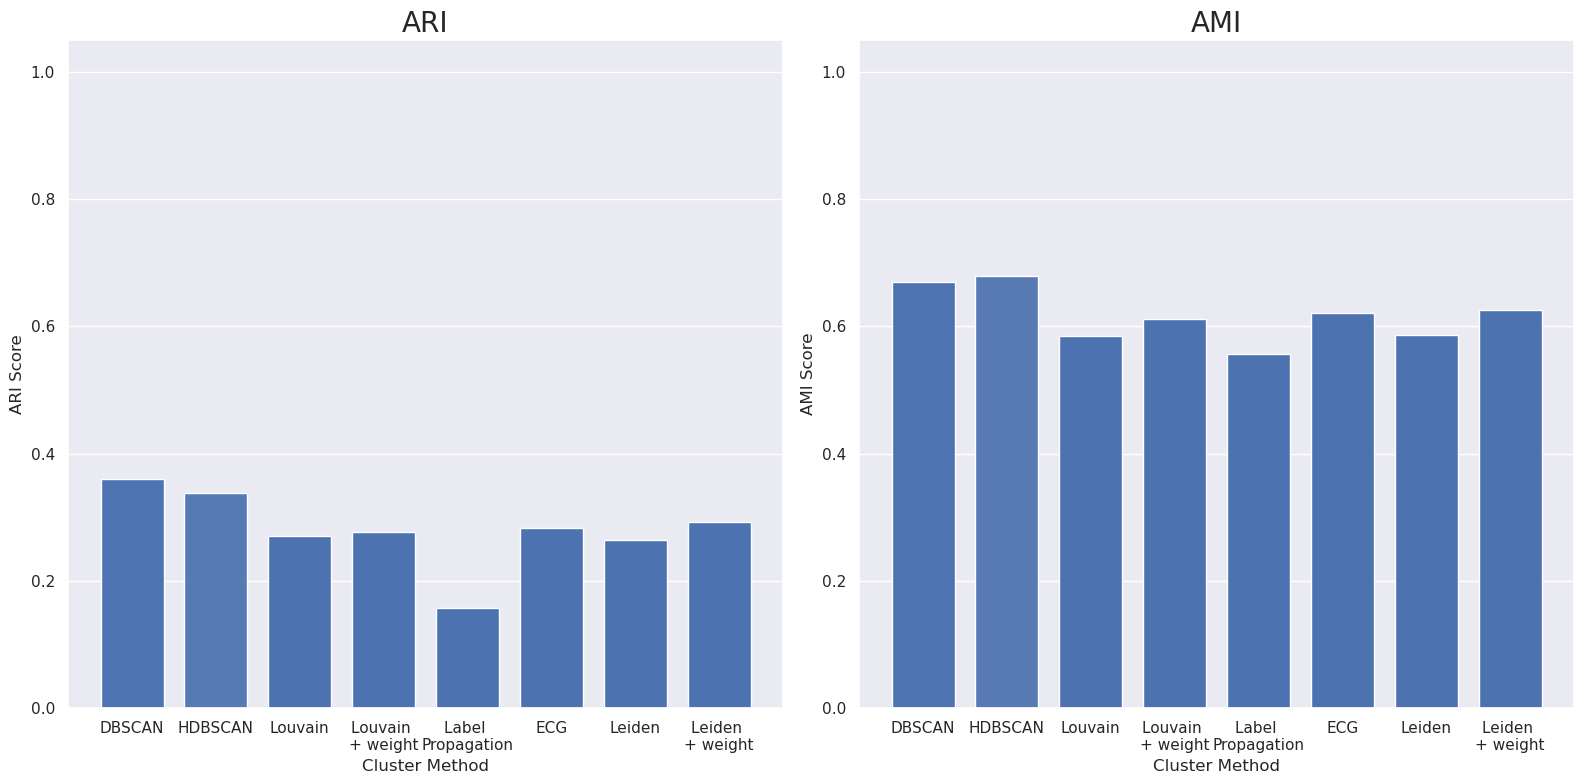

In [48]:
print_summary(clustering_results_buildings, G_buildings)
plot_scores(buildings_umap_results_long)